# Assignment 04
## Clustering Models
## CSCI S-96    

> **Instructions:** For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial [here](https://www.markdownguide.org/cheat-sheet/).   



## Introduction    

**Clustering models** are core data mining methods. Clustering models are also known as **unsupervised learning** models. The goal of these models is to extract structure and relationships from complex data. Carrying out this type of exploration is difficult since there is no ground truth as a basis of comparison. 

In this assignment you will work with a complex human resources data set to explore the basic concepts of clustering. Specifically, you will use a [human resources (HR) dataset from Kaggle](https://www.kaggle.com/jacksonchou/hr-analytics). The business goal is to discover common attributes common to employees who leave a large company prematurely in the data. You will use multiple clustering algorithms to build an understanding of the relationships between the variables. Since we do not know in advance which sets of common attributes are important in an employees decision to leave, this is a perfect application for clustering methods.   

Evaluation of any unsupervised learning model is a difficult task at the best of times. In this assignment you will use a combination of numeric and graphical evaluation methods. The scope of model evaluation and comparison has deliberately been limited here. Many more methods can and should be applied to complex real-world problems. Regardless of the evaluation methods applied, interpretation of clustering model results remains difficult and requires judgment. 

As you proceed with the exercises, keep in mind that the relationships in this data set are complex. There are unlikely to be one or just a few simple reasons why a long-term employee chooses to leave their job. Consequently, you should not expect simple well defined results for any analytical model. This type of difficulty and complexity is inherent in many real-world applications of unsupervised learning.    

The cluster models you will apply in this assignment have many hyperparameters. To limit the scope of the exercises, values for many hyperparameters are specified in many cases. These values were found by limited exploration of the hyperparameter space. For a real-world project a great deal more time-consuming exploration would be required. 

> **Important Note:** You will need about 2 GB of free RAM to execute the exercises in this notebook. 


### Load and explore the data   

As a first step in this analysis, execute the code in the cell below to import the required packages. 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from patsy import dmatrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

Next, execute the code in the cell below to import the dataset and display the data types of the columns.  

In [2]:
HR_data = pd.read_csv('../data/HR_comma_sep.csv')
HR_data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

There are several data types here. The first two variables have floating point numeric values. There are several integer numeric values. And, finally the last two columns appear to have categorical values.  

One question to ask about these data is how many unique levels are there in the columns which are not floating point numbers? To investigate the answer, execute the code in the cell below and examine the results.  

In [3]:
for col in HR_data.columns[2:]:  
    print('\n' + col)
    print(HR_data[col].unique())


number_project
[2 5 7 6 4 3]

average_montly_hours
[157 262 272 223 159 153 247 259 224 142 135 305 234 148 137 143 160 255
 282 147 304 139 158 242 239 128 132 294 134 145 140 246 126 306 152 269
 127 281 276 182 273 307 309 225 226 308 244 286 161 264 277 275 149 295
 151 249 291 232 130 129 155 265 279 284 221 154 150 267 257 177 144 289
 258 263 251 133 216 300 138 260 183 250 292 283 245 256 278 240 136 301
 243 296 274 164 146 261 285 141 297 156 287 219 254 228 131 252 236 270
 298 192 248 266 238 229 233 268 231 253 302 271 290 235 293 241 218 199
 180 195 237 227 172 206 181 217 310 214 198 211 222 213 202 184 204 288
 220 299 303 212 196 179 205 230 203 280 169 188 178 175 166 163 168 165
 189 162 215 193 176 191 174 201 208 171 111 104 106 100 194 209 185 200
 207 187 210 186 167 108 122 110 115 197 102 109 190  99 101  97 173 121
 170 105 118 119 117 114  96  98 107 123 116 125 113 120 112 124 103]

time_spend_company
[ 3  6  4  5  2  8 10  7]

Work_accident
[0 1]

left
[1

There is a variety of information types encoded in these variables.  
1. **Ordinal** integer variables. An ordinal variable has an ordered set of values. In this case, several ordinal variables are numeric. But, `salary` is coded by categories.    
2. Several binary variables, coded as $\{0,1 \}$.    
3. One categorical variable, `sales`, which are job categories. 

To better understand some of the numeric variables it is useful to create histograms. Execute the code in the cell below and examine the histograms displayed.     

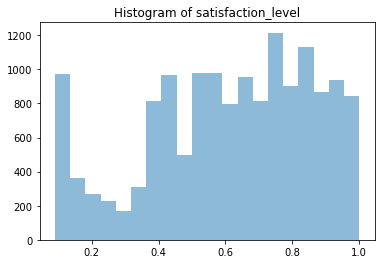

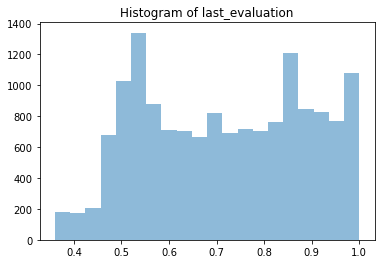

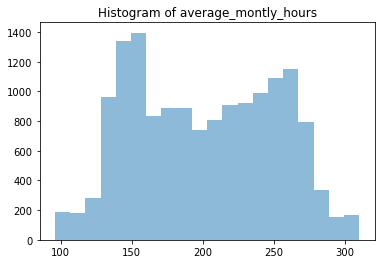

In [4]:
for col in ['satisfaction_level','last_evaluation','average_montly_hours']:
    plt.hist(HR_data.loc[:,col], bins=20, alpha=0.5)
    plt.title('Histogram of ' + col)
    plt.show()

None of these variables are remotely close to a Normal distribution. In fact, these variables look closer to a uniform distribution.      


### Preparing the data   

With some understanding of the variables, we must now prepare the dataset for the analysis. For clustering algorithms we must restrict ourselves to encoding that preserves our ability to compute the required distance metrics. Still there are a number possible distance metrics and encoding options we can choose from.  

For the examples in this notebook we will use data encoding suitable for Euclidean and L1 distances. The choice of Euclidean distance, in particular, dictates that we scale numeric features. Additionally, we will minimize the number of binary features.   
As a first step in this process, we must convert the ordinal variable `salary` to a numeric type. The code in the cell below limits the numeric values to the range $[0,1]$ and maintains the order. Execute this code and note the result 

In [5]:
salary_levels = {'low':0, 'medium':0.5, 'high':1.0}
HR_data.loc[:,'salary'] = [salary_levels[x] for x in HR_data.loc[:,'salary']]
HR_data.loc[:,'salary'].value_counts()

0.0    7316
0.5    6446
1.0    1237
Name: salary, dtype: int64

The `sales` variable presents a particular problem. This variable is categorical and there is no sensible ordering. There is no idea solution. In this case we will recode this variable indicating if the position is in sales or something else. This approach avoids creating a larger number of binary dummy variables. Execute the code in the cell below and examine the results. 

In [6]:
HR_data.loc[:,'sales'] = [1 if x=='sales' else 0 for x in HR_data.loc[:,'sales']]
HR_data.loc[:,'sales'].value_counts()

0    10859
1     4140
Name: sales, dtype: int64

About 1/3 of the employees are in sales, so this coding is reasonable from this point of view. 

Finally, we must normalize the numeric variables. Since the distribution is far from Normal, Z-score normalization is likely to be a poor choice. Instead, we will use the [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). By default, this scale transforms the scale of each variable to be in the $[0.1]$ range. Such scaling in optimal for uniformly distributed variables, and a good choice for variables that are approximately uniform.  

The code in the cell below applies the Min-Max scaler to the numeric columns. Execute this code and examine the results.  

In [7]:
normalize_cols = ['satisfaction_level','last_evaluation','average_montly_hours','number_project','time_spend_company']
HR_data.loc[:,normalize_cols] = MinMaxScaler().fit_transform(HR_data.loc[:,normalize_cols])
HR_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0            0.318681         0.265625             0.0              0.285047   
1            0.780220         0.781250             0.6              0.775701   
2            0.021978         0.812500             1.0              0.822430   
3            0.692308         0.796875             0.6              0.593458   
4            0.307692         0.250000             0.0              0.294393   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0               0.125              0     1                      0      1   
1               0.500              0     1                      0      1   
2               0.250              0     1                      0      1   
3               0.375              0     1                      0      1   
4               0.125              0     1                      0      1   

   salary  
0     0.0  
1     0.5  
2     0.5  
3     0.0  
4     0.0

The variable values in the data frame are all in the $[0,1]$ range. No variable will dominate the models simply by having numerically large values. 

## K-Means Clustering  

K-means clustering separates a dataset into K clusters of equal variance. The number of clusters, K, is user defined. The basic algorithm has the following steps:
1. A set of K centroids are randomly chosen. 
2. Clusters are formed by minimizing variance within each cluster. This metric is also know as the **within cluster sum of squares** (see further discussion in the section on evaluating clusters). This step partitions the data into clusters with minimum squared distance to the centroid of the cluster. 
3. The centroids are moved to mean of each cluster. The means of each cluster is computed and the centroid is moved to the mean. 
4. Steps 2 and 3 are repeated until a stopping criteria is met. Typically, the algorithm terminates when the within cluster variance decreases only minimally. 
5. The above steps are repeated starting with a random start of step 1. The best set of clusters by within cluster variance and between cluster separation are retained.  

Since K-means clustering relies only on basic linear algebra operations, the method is massively scalable. Out-of-core K-means clustering algorithms are widely used. However, this method assumes equal variance of the clusters, a fairly restrictive assumption. In practice, this criteria is almost never true, and yet K-means clustering still produces useful results. 

### K-means clustering example

Let's try a simple example, applying the k-means algorithm to the prepared HR data. In this case we will use the [sklearn.clustering.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) package to compute cluster assignments using $k=4$.  

The code in the cell below creates a k-means cluster object, and computes the cluster assignments with the `fit_predict` method. A frequency table of the cluster assignments by the value of the `left` variable is then displayed. Execute this code and examine the results.     

In [8]:
nr.seed(4455)
HR_data['cluster_assignments'] = KMeans(n_clusters=4).fit_predict(HR_data)
## Create a frequency table of the number of employees leaving by cluster assignment  
HR_data.loc[:,['cluster_assignments','left']].value_counts()

cluster_assignments  left
0                    0       6843
3                    1       3511
1                    0       2585
2                    0       2000
                     1         60
dtype: int64

Notice that most of the employees who left the company are in a single cluster. Further, this cluster has no employees who did not leave assigned. This appears promising in terms of understanding employees who leave.   

We might consider which factors might be important in compelling employees to leave the company. Visualization of clustering results can be difficult, but with some effort important insight can be gained. Like most data visualization, a number of ideas must be tested. Most visualizations will not be that useful, but a few will be.   

For this case, we will start by displaying a scatter plot matrix of some of the variables. The hue is used to display the cluster assignments. Execute the code and examine the results.  

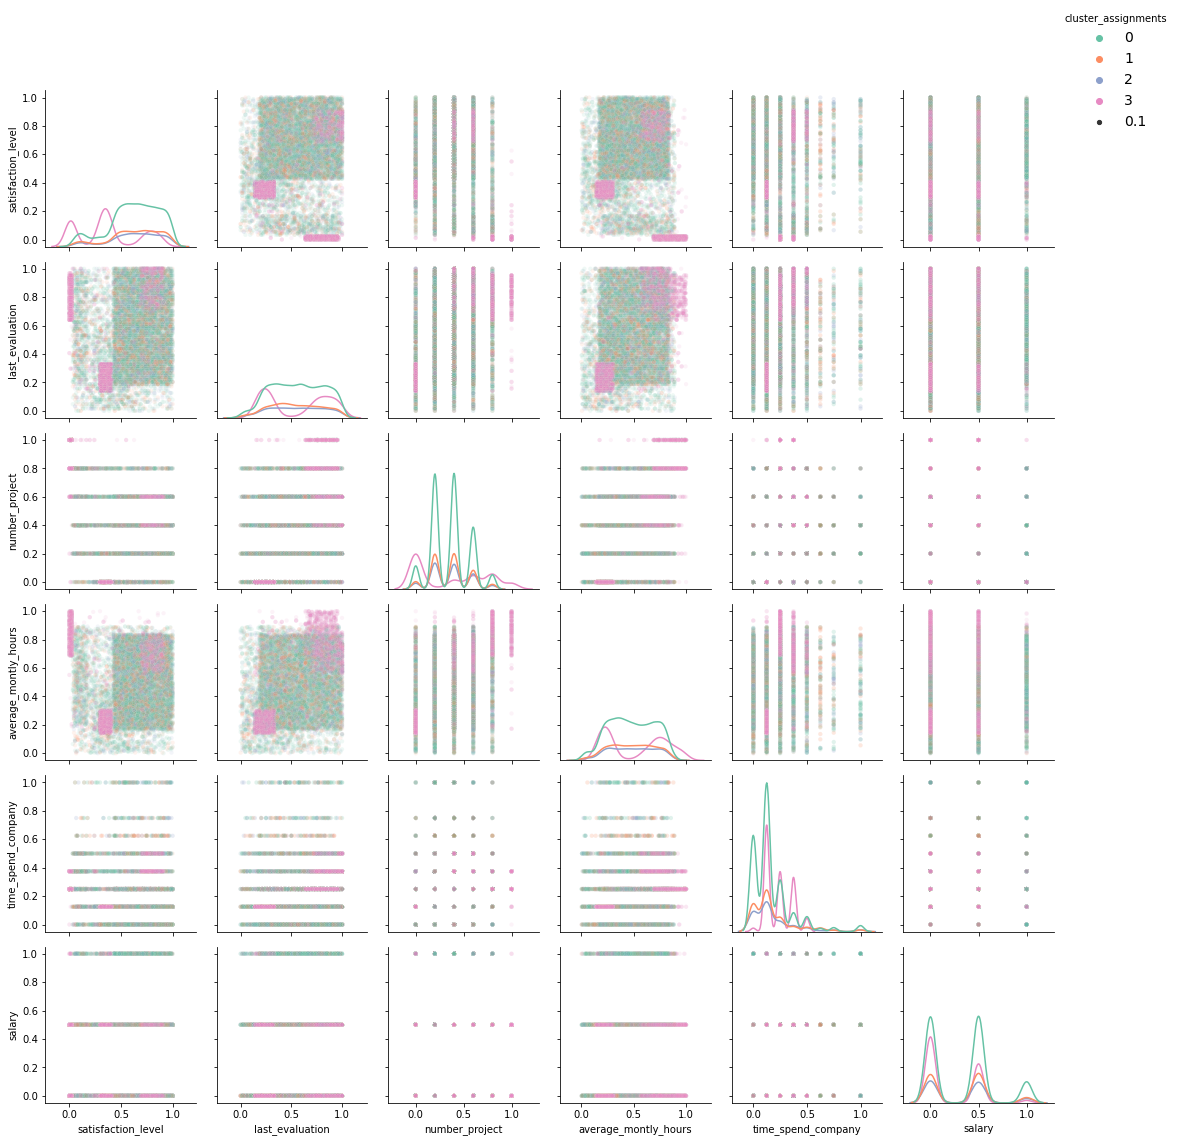

In [9]:
def plot_cluster_assignments(df):
    display_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'salary', 'cluster_assignments']
    g = sns.PairGrid(HR_data.loc[:,display_columns], hue='cluster_assignments', palette='Set2');
    g.map_diag(sns.kdeplot);
    g.map_offdiag(sns.scatterplot, size=0.1, alpha=0.1);
    g = g.add_legend(fontsize=14, bbox_to_anchor=(1,1));

plot_cluster_assignments(HR_data)

Notice the position of to points for cluster 2, which contains most of the employees who left the company. Many of the points in cluster 2 are in close proximity within several regions of the scatter plots. But, ideally the points of one cluster should in a single compact group.        

Next, we will display and examine some violin plots. Execute the code in the cell below to display violin plots of satisfaction level, number of projects, and average monthly hours by cluster assignment. Hue is used to show the left variable. These variables are chosen since clusters containing records of employees who left the company are in a reasonably small range along these axes in the scatter plot matrix. 

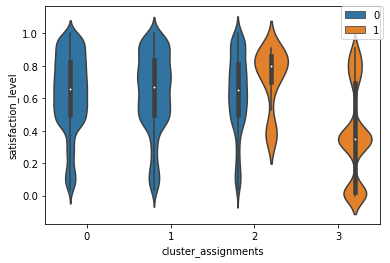

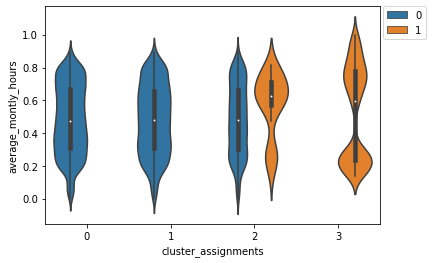

In [10]:
def plot_clusters_by_factor(df, factor='satisfaction_level', type='violin'):
    plt.figure(figsize=(6,4))
    if(type=='violin'):
        sns.violinplot(x='cluster_assignments', y=factor, hue='left', data=df)
    else: 
        sns.boxplot(x='cluster_assignments', y=factor, hue='left', data=df)
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    
plot_clusters_by_factor(HR_data)    
plot_clusters_by_factor(HR_data, factor='number_project')  
plot_clusters_by_factor(HR_data, factor='average_montly_hours')  

## Evaluating cluster models

Now that you have created some clustering models, you are likely wondering how can you evaluate these models and perform model selection. There are a number of metrics you can use to evaluate and compare clustering models. However, you should always keep in mind that the best model, should be selected based on the problem you are trying to solve.

One useful metric for clusters is the **within cluster sum of squares** or **WCSS**. Intuitively, clusters should have minimal dispersion and therefore minimal WCSS. The  

$$WCSS = Min \sum_i \sum_{j\ in\ cluster\ i} ||x_j - c_i||^2 \\
where\\
c_i = center\ of\ ith\ cluster\\ 
and\\
||x_j - c_i|| = distance\ between\ data\ x_j\ and\ center\ c_i
$$

We can use WCSS to compare different cluster models. Models with smaller SSW have tighter clusters and, therefore smaller WCSS. 


> **Note:** WCSS is also referred to as **inertia**, an analogy with classical mechanics in physics. 


The **between cluster sum of squares** or **BCSS** is a related metric. Whereas WCSS measures how tight the clusters are BCSS is a measure of the separation between the clusters. To compute the BCSS, observe that the **total sum of squares** or **TSS** must equal the sum of the WCSS and BCSS:

$$
TSS = BCSS + WCSS\\
where\\
TSS = \sum_i (x_i - \mu)^2\\
where\\
\mu = mean\ of\ all\ data\ samples
$$

Notice that the TSS is just the variance of all data points. The BCSS is then just the difference between TSS and WCSS.


> **Note:** The WCSS and BCSS metrics have the concept of the clustering having multivariate-Normal distributions. Therefore, these metrics are strictly only applicable to K-means cluster. This fact means that WCSS and BCSS are not useful metrics for agglomerative clustering. The SC can be computed using various metrics so is more generally applicable to most clustering methods. 


### Finding the number of clusters

We have investigated our first k-means cluster model with $k = 4$. The next question is, how many clusters ($k$) are optimal. As we are dealing with unsupervised learning models the answer is generally not obvious. 

One approach to determining the number of clusters is to plot the within cluster sum of squares (WCSS) against the number of clusters. The code in the cell below creates just such a plot by the following steps:
1. Any existing cluster assignments are removed from the data frame. It is critical that assignments from other models not bias the training of the new models. 
2. A list of k-means cluster models are computed over a range of $k$ values. 
3. The **inertia** or WCSS is saved for each model computed.  
4. A plot is made of the WCSS vs. the number of clusters. 

Execute this code and examine the result.

In [11]:
def cluster_search_kmeans(df, nclusts=(2,10)):
    ## If there are cluster assignments in the data frame remove them. 
    if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
    WCSS=[]
    ## Put your code below
    for i in range(nclusts[0], (nclusts[1] + 1)):
        kmeans = KMeans(n_clusters=i).fit(df)
        WCSS.append(kmeans.inertia_)
    
    plt.plot(range(nclusts[0],nclusts[1]+1),WCSS)   
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
cluster_search_kmeans(HR_data)    

As expected, the slope of the WCSS curve drops rapidly as the number of clusters increases. The question is, where is the best cutoff that leads to an informative, but not over-fit model? This choice is partially subjective. In a more detailed analysis, several models can be compared. In this case, the curve flattens past $k=8$, so we will use an 8 cluster model.  

> **Exercise 04-1:** In the cell below create and execute code to do the following: 
> 1. Make sure you first remove the `cluster_assignments` column if present. 
> 2. Save the start time of execution of your cluster model using the [time.process_time](https://docs.python.org/3/library/time.html) function. 
> 3. Compute an k=8 cluster model for the HR dataset, using the `fit_predict` method, and assign the clusters from the model.  
> 4. Print the execution time as the difference between the current 'process_time' and the saved starting time. 
> 5. Display a frequency table of cluster assignments by value of the `left` variable

In [12]:
nr.seed(7722)
## Put your code below
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
    
## Get the start time for the k-means algorithm and execute the algorithm
start_time = time.process_time()

HR_data['cluster_assignments'] = KMeans(n_clusters=8).fit_predict(HR_data)

## Display the execution time
end_time = time.process_time()
print("Current Process Execution Time Is: ", (end_time - start_time))

## Dispaly the frequence table by cluster assignment
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

Current Process Execution Time Is:  1.4785769999999943


cluster_assignments  left
0                    0       2585
1                    0       2000
                     1          4
2                    0       3805
3                    1       1140
4                    1        522
5                    1       1413
6                    0       3038
7                    1        492
dtype: int64

> Examine the frequency table and answer the following questions:  
> 1. Are there clusters which contain the majority of records for the employees who left the company?  
> 2. Do the foregoing clusters contain any records for employees who stayed with the company?   
> 3. Given your answers to the foregoing questions, do you think the model can provide useful insight into characteristics of customers who leave the company?   

> **Exercise 04-2:** To further evaluate the model you have computed, create execute the code in the cell below to display the pairs plot using the `plot_cluster_assignments` function.   

Note. I am interpreting the results as left = 1 means "left the company" and left = 0 "has not left the company".

> 1. Clusters 5 and 3 contain a majority of the records for employees that left.
> 2. No they do not contain any records for employees who stayed.
> 3. I think it is possible. It gives you the ability to compare clusters where everyone left vs clusters where everyone stayed and take a look at how these clusters differ from one another for the different variables.

In [13]:
plot_cluster_assignments(HR_data)


/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


> Examine the plot. Do the clusters which contain the majority of records of employees who have left the company appear in the reasonably small regions of the scatter plots?

> Next, you will display and examine some violin plots. Create and execute the code in the cell below to display violin plots of satisfaction level, number of projects, and average monthly hours by cluster assignment. Hue is used to show the left variable. These variables are chosen since clusters containing records of employees who left the company are in a reasonably small range along these axes in the scatter plot matrix. 

 Cluster 5, 3 are showing small, distinct regions on the plot.

Cluster 5 looks like lowly satisfied, high achivers that work on a lot of projects and work long hours.

Cluster 3 looks like low to mid satisfaction, under achievers, that work on a few projectss and don't work many hours.



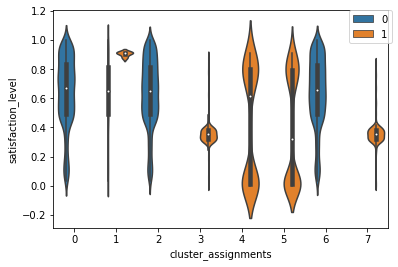

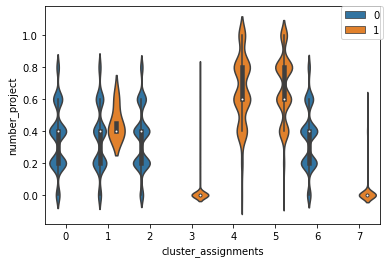

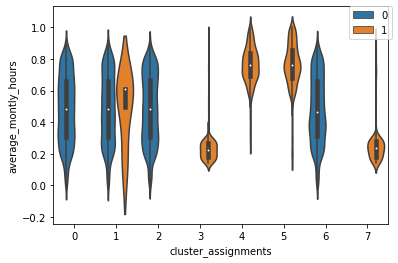

In [14]:

plot_clusters_by_factor(HR_data)    
plot_clusters_by_factor(HR_data, factor='number_project')  
plot_clusters_by_factor(HR_data, factor='average_montly_hours')  

> We can make some inferences from these results. Answer the following question:  
> 1. Unsurprisingly, employees leaving tend to have the lowest satisfaction scores. But is this always the case, or is there something else prompting employees to leave?      
> 2. What can you say about the effect of high and low numbers of projects on the likelihood of an employee leaving?   
> 3. What can you say about the effect of high and low average monthly hours worked on the likelihood of an employee leaving?     
> **End of exercise.**

1. It sseems like working on a large number of projects and working long hours causes employess to want to leave.

2. It looks like both extreme ends of the spectrum cause employees to leave (being either bored or overworked). The sweet spot for keeping employees is right in the middle. However, working on a large number of projects seems to cause both satisfied and unsatisfied employees to leave.

3. High monthly hours are more likely to make employees leave. Low monthly hours can cause a person to leave if they already have a below average satisfaction level.

## Mini-Batch K-Means

The mini-batch K-means algorithm follows the same steps as the conventional (Batch) K-means algorithms. However at each step, a randomly selected mini-batch is used to update cluster centers and cluster assignments. This algorithm iterates through mini-batches until convergence. 

> **Exercise 04-3:** You will now create and benchmark code to implement the mini-batch K-means algorithm. You will use the [sklearn.clustering.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) function. Use the arguments `n_clusters=8` and `batch_size=25`, using the `fit_predict` method, and assign the clusters from the model. Use the `time.process_time` function to capture the execution time. When the cluster calculation is completed, generated and print the frequency table of the cluster assignments.    

In [15]:
nr.seed(7722)
## Put your code below
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
    
## Get the start time for the k-means algorithm and execute the algorithm
start_time = time.process_time()

HR_data['cluster_assignments'] = MiniBatchKMeans(n_clusters=8, batch_size=25).fit_predict(HR_data)

## Display the execution time
end_time = time.process_time()
print("Current Process Execution Time Is: ", (end_time - start_time))


## Print the frequency table by cluster assignments
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

Current Process Execution Time Is:  0.196191000000006


cluster_assignments  left
0                    0       3013
1                    0       2517
2                    1       1927
3                    0       1787
4                    0       1928
                     1         18
5                    0       1883
6                    0        300
                     1          1
7                    1       1625
dtype: int64

> Examine your results and answer these questions:  
> - Compare the execution time to the execution time for the batch K-means. How much of a speed improvement has the mini-batch algorithm achieved?   
> - Compare the number of assignments of cases of leaving employees assigned to clusters with predominantly cases of non-leaving employees to the same labeled cases for the k=8 full batch algorithm. What can you say about the mini-batch solution vs. the full batch solution?
>**End of exercise.**

1) The exectutuion time is about 7 times faster.

2) In the full batch solution there was only one cluster where leaving employees were assigned to a cluster with predominantly non-leaving employees. In the mini-batch solution there were 2 instances of this happening. In my opinion I think this makes mini-batch a worse clustering method for this use case.

## Introduction to Hierarchical Clustering

Another widely used form of clustering uses heirarchical modes. These models attempt to divide or partition the data following a heirarchical sequence. 

Heirachical clustering models produce a tree-like organization of the data into a hierarchy of clusters. At the root of the tree, all data cases are in one large cluster. The leaves of the tree each have a cluster with a single data case.

Heirachical clustering models generally use one of two approaches. 

1. **Agglomerative clustering** works from the leaves of the tree toward the root in the following way.
  - All data cases start in their own cluster. 
  - Pairs of clusters are merged to their nearest neighbors over several interations. 
  - The second step is repeated until there is one cluster at the root of the tree. 
2. **Divisive clustering** works from the root of the tree toward the leaves in the following way.
  - All data cases start in a single large cluster. 
  - Clusters are split into two parts in a way that maximizes the distance (or disimilarity) between the clusters. 
  - The second step is repeated until there the leaves of the tree, each with a single data case, is encountered. 
  
  
With the above descriptions of the algorithms in mind, we need to discuss how distance is measured. 

First, we use a **distance metric** to compute the distance between two individual data points. We have already encountered some of the most widely used metrics, **Euclidean** and **Manhattan**. 

Since clusters are typically made up of multiple points we need a way to combine the distances between the points in clusters. We do this through **linkage functions**. There are several commonly used linkage functions. For a distance metric value between two points, $a$ in the one cluster, and $b$ in the other cluster, $D(a,b)$, we can define some common linkage functions:

1. **Ward's method** is a linkage method that uses a minimum variance criteria to select the pairs of smaller clusters to link.  
2. **Maximum or complete-linkage** is the largest value of the distance metric between any pairs of points in the two clusters. 
$$= Max \big( D(a,b) \big)$$
3. **Minimum or single-linkage** is the smallest value of the distance metric between any pairs of points in the two clusters. 
$$= Min \big( D(a,b) \big)$$
4. **Mean or average linkage** is the average of the distance metrics between all pairs of points in the two clusters.
$$= \frac{1}{N_{ab}} \sum D(a,b)\\ 
where\\
N_{ab}\ is\ the\ count\ of\ pair-wise\ distances$$
5. **Centroid linkage** is the distance metric between the centroids between the two clusters. 
$$= |c_1 - c_2|\\
where\\
c_1, c_2\ are\ centroids\ of\ clusters\ 1\ and\ 2$$

As you can imagine, the choice of distance metric and linkage function can significantly change the clustering relationships a model finds. 

### Agglomerative clustering example   

With the foregoing theory in mind, its time to try an example using the HR dataset. We have already explored k-means clustering on this dataset. Recall that the k-means method is only defined for the Euclidean distance metric.  

The agglomerative clustering algorithm, like all hierarchical clustering algorithms, Allows the choice of both a linkage method and a wide range of distance metrics. In this first example we will use complete linkage which uses the maximum distance between any two points within two clusters. We will also use the Manhattan distance metric.  

The code in the cell below creates and fits an agglomerative cluster model and then displays the resulting frequency table. Execute this code and examine the results.

In [16]:
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
model_agglomerative =  AgglomerativeClustering(n_clusters=4, linkage='complete', affinity='manhattan')   
HR_data['cluster_assignments'] = model_agglomerative.fit_predict(HR_data)
HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

cluster_assignments  left
0                    0       8114
1                    0       3031
                     1        497
2                    1       3073
3                    0        283
                     1          1
dtype: int64

There is one cluster containing most of the records of the employees who left the company.   

Execute the code in the cell below to create the scatter plot matrix of some of the variables with the hue showing cluster assignments. 

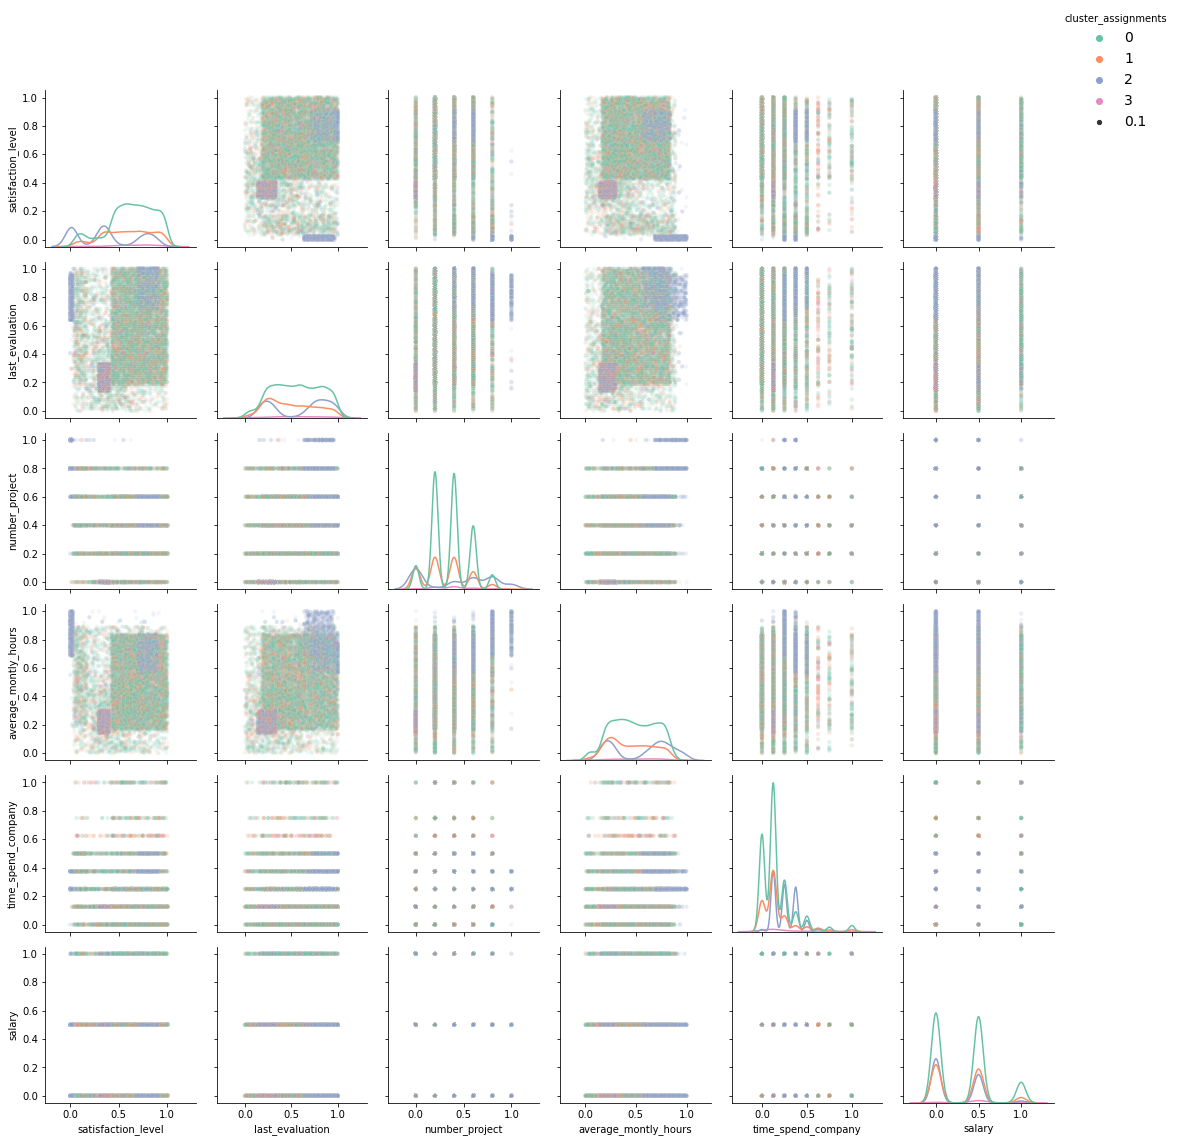

In [17]:
plot_cluster_assignments(HR_data)

The records assigned to the cluster with the employees who left the company fall in several groups on the graphs. While it is good most of these records are in one cluster, interpreting the characteristics of these employees in a meaningful way will be difficult at best.      

### Evaluating number of clusters

Given the foregoing results it seems entirely possible that the a different number of clusters might provide better insight into to structure of the data. But how can we evaluate the clusters? With non-Euclidean We cannot use the WCSS. We need an alternative. There are several possibilities     

In this case we will use **Maximum diameter of clusters**. As more clusters are used in a model the clusters become smaller. But, as the model becomes complex, the reduction in the size of the clusters diminishes. The distance must be measured using the clustering distance metric. The maximum diameter of cluster, $C_i$, is:  

$$diameter(C_i) = max_{j,k \in C_i} d(x_j,x_k)$$    



The code in the cell below does the following:    
1. Iterates over each cluster.    
  - The cluster assignment column is deleted.
  - A new model is computed
  - Cluster assignments are made with the predict method. 
  - The `find_max_diameter` function is called. This function iterates over all cluster assignments, computing the maximum diameter of each. The maximum of the maximum is then returned.      
2. Plots the maximum of the diameter of the clusters for each value of $k$.   

Execute the code and examine the results. Since hierarchical clustering is computationally intensive, execution of this code may take some time.  

[7.677401920509397,
 7.433499794597925,
 6.392194079285201,
 6.345988882612714,
 6.159535470370751,
 5.880169071582623,
 5.72398037126425,
 5.239012272773955,
 5.198759243093355,
 4.983348631508679,
 4.9413743966314065]

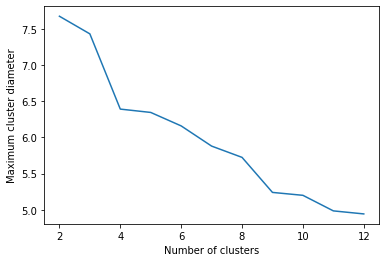

In [18]:
def find_max_diameter(df, metric='manhattan'):
    max_diameters = []
    for assignment in df['cluster_assignments'].unique(): 
        temp_X = df[df['cluster_assignments']==assignment]
        max_diameters.append(np.amax(pairwise_distances(temp_X, metric=metric))) 
    return np.amax(max_diameters)   

def evaluate_agglomerative_clusters(df, metric='manhattan', linkage='complete', nclusts=(2,12)): 
    max_diameters = []
    for n in range(nclusts[0],nclusts[1]+1):
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        model_agglomerative =  AgglomerativeClustering(n_clusters=n, linkage=linkage, affinity=metric)   
        df['cluster_assignments'] = model_agglomerative.fit_predict(df)
        max_diameters.append(find_max_diameter(df, metric=metric))
        
        
        
    plt.plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    plt.xlabel('Number of clusters')
    plt.ylabel('Maximum cluster diameter')
    return max_diameters     
    
evaluate_agglomerative_clusters(HR_data)    

Examine the plot. The curve is not smooth. A flattening of the curve starting at 9 clusters is evident. Therefore, we will use 9 clusters for the analysis.   

> **Exercise 04-4:** In the cell below create and execute code to do the following:   
> 1. Delete the cluster assignment column if one is present.   
> 2. Compute the 9 cluster model with complete linkage and the Manhattan distance metric, using the `fit_predict` method, and assign the clusters from the model.   
> 4. Display a frequency table of the `left` variable by cluster assignment.  

In [19]:
nr.seed(2323)
if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
    
model_agglomerative =  AgglomerativeClustering(n_clusters=9, linkage='complete', affinity='manhattan')

HR_data['cluster_assignments'] = model_agglomerative.fit_predict(HR_data)

HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)


cluster_assignments  left
0                    0       1431
1                    1       1175
2                    1       1898
3                    0       2517
4                    0       6683
5                    1        497
6                    0        228
7                    0         55
                     1          1
8                    0        514
dtype: int64

> Answer the following questions.   
> - Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> - Given the above, does this model appear to identify some structure in the data which might provide insight into employees leaving the company?    

> To further evaluate this model, create and execute the code in the cell below to display the pair-wise scatter plot matrix and examine the results.    

Yes, all but one employee that left a company appeared in clusters solely populated by other employees that also left.

Yes, this model appears to to identify some insightul structure in the data that explains why employees leave a company.

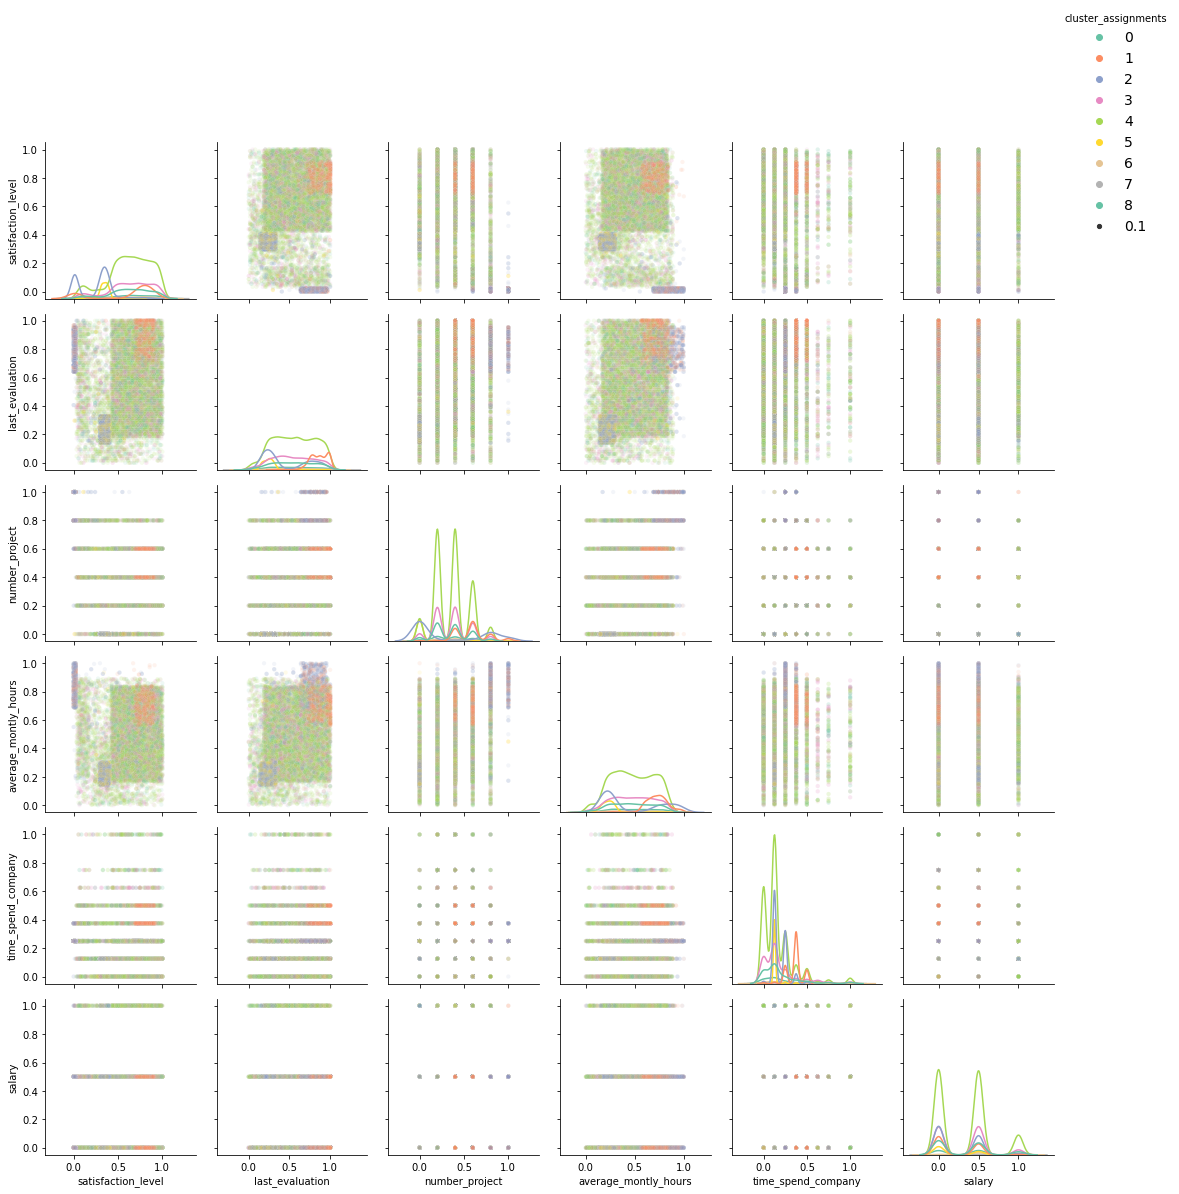

In [20]:
plot_cluster_assignments(HR_data)


> Examine this plot displaying 9 clusters. Are the clusters containing the employees leaving displayed in the plots in tight (small) clusters?     

> Next, create and execute the violin plot code in the cell below to further explore the relationships in the clusters. Do this for satisfaction level, number of projects, and average monthly hours by cluster assignment.

Yes clusters 1 and 2 which contain a majority of the employees that left appear in tight clusters with a clear structure to them.

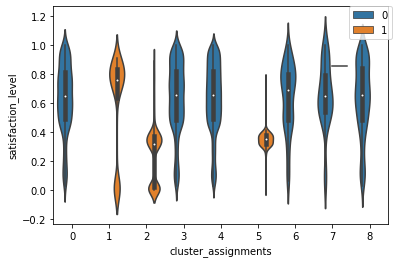

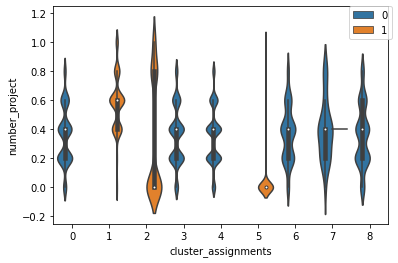

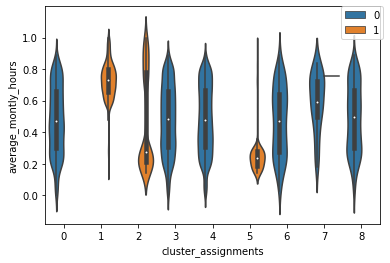

In [21]:
plot_clusters_by_factor(HR_data)    
plot_clusters_by_factor(HR_data, factor='number_project')  
plot_clusters_by_factor(HR_data, factor='average_montly_hours') 


> These results look similar to the those from the 8 cluster k-means algorithm. However, in detail there are some differences representing the different algorithms used. Some points to notice here include:   
> - Is there evidence that employees with low satisfaction are likely to leave the company? 
> - Is there evidence that employees with high and low numbers of projects and average monthly hours worked are likely to leave the company?       
> **End of exercise.**

Yes there is evidence that employees with low ssatisfaction are likely to leave the company regardless of the number of projects / hours worked. 

yes the plots show that even if employees have a fairly high satisfaction level, if they have a large number of projects and a high number of average monthly hours they are more likely to leave.

## Using a Different Encoding   

We have applied two types of clustering models using different distance metrics to the HR dataset. Now we will explore the question of what happens when we apply a different encoding to the raw data. Using this scaling we will test using **cosine distance** as the metric. We will proceed cautiously, since generally cosine distance is used for purely categorical data, and this dataset contains several numeric features.     

Specifically, we will expand the `sales`, or job type, into dummy variable columns to encode each job type. The scaling is also modified to ensure the variables are in the range $[-1,1]$. The scaling is often optimal for use with cosine similarity since differences in this range over $\theta = \pi$ rather than just $\theta = \pi/2$.   

The code in the cell below performs the following steps to encode the dataset.  
1. The numeric columns are normalized using min-max scaling.    
2. The ordinal variable `salary_level` is encoded on a $[0,1]$ scale.  
3. The `salary` column is one-hot encoded into binary dummy variables. 
4. The variables are scaled into a range $[-1,1]$ using the transformation $2*value - 1$

Execute the code and examine the resulting data frame.  

In [22]:
## Get a fresh copy of the data
HR_data_cosine = pd.read_csv('../data/HR_comma_sep.csv')

## Normalize some numeric value columns
normalize_cols = ['satisfaction_level','last_evaluation','average_montly_hours','number_project', 'time_spend_company']
HR_data_cosine.loc[:,normalize_cols] = MinMaxScaler().fit_transform(HR_data_cosine.loc[:,normalize_cols])

## Recode the ordinal salary range to 0-1 
salary_levels = {'low':0.0, 'medium':0.5, 'high':1.0}
HR_data_cosine.loc[:,'salary'] = [salary_levels[x] for x in HR_data_cosine.loc[:,'salary']]

## One-hot encode the categorical columns and normalize by number of categories    
encoded_columns = OneHotEncoder().fit_transform(np.array(HR_data_cosine.loc[:,'sales']).reshape(-1, 1)).toarray()
#encoded_columns = np.divide(encoded_columns, encoded_columns.shape[0]) # float(len(HR_data_cosine.loc[:,'sales'].unique)))
HR_data_cosine[HR_data_cosine.sales.unique()] = encoded_columns

## Finally, transform the feature values to the [-1,1] to improve sensitivity with cosine distance
HR_data_cosine.loc[:,HR_data_cosine.columns] = np.subtract(np.multiply(HR_data_cosine,2.0),1.0)

HR_data_cosine

satisfaction_level  last_evaluation  number_project  \
0               -0.362637         -0.46875            -1.0   
1                0.560440          0.56250             0.2   
2               -0.956044          0.62500             1.0   
3                0.384615          0.59375             0.2   
4               -0.384615         -0.50000            -1.0   
...                   ...              ...             ...   
14994           -0.318681         -0.34375            -1.0   
14995           -0.384615         -0.62500            -1.0   
14996           -0.384615         -0.46875            -1.0   
14997           -0.956044          0.87500             0.6   
14998           -0.384615         -0.50000            -1.0   

       average_montly_hours  time_spend_company  Work_accident  left  \
0                 -0.429907               -0.75           -1.0   1.0   
1                  0.551402                0.00           -1.0   1.0   
2                  0.644860               -0.50           -1.0   1.0   
3                  0.186916               -0.25           -1.0   1.0   
4                 -0.411215               -0.75           -1.0   1.0   
...                     ...                 ...            ...   ...   
14994             -0.485981               -0.75           -1.0   1.0   
14995             -0.401869               -0.75           -1.0   1.0   
14996             -0.560748               -0.75           -1.0   1.0   
14997              0.719626               -0.50           -1.0   1.0   
14998             -0.420561               -0.75           -1.0   1.0   

       promotion_last_5years  sales  salary  accounting   hr  technical  \
0                       -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
1                       -1.0   -1.0     0.0        -1.0 -1.0       -1.0   
2                       -1.0   -1.0     0.0        -1.0 -1.0       -1.0   
3                       -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
4                       -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
...                      ...    ...     ...         ...  ...        ...   
14994                   -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
14995                   -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
14996                   -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
14997                   -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   
14998                   -1.0   -1.0    -1.0        -1.0 -1.0       -1.0   

       support  management   IT  product_mng  marketing  RandD  
0         -1.0        -1.0 -1.0          1.0       -1.0   -1.0  
1         -1.0        -1.0 -1.0          1.0       -1.0   -1.0  
2         -1.0        -1.0 -1.0          1.0       -1.0   -1.0  
3         -1.0        -1.0 -1.0          1.0       -1.0   -1.0  
4         -1.0        -1.0 -1.0          1.0       -1.0   -1.0  
...        ...         ...  ...          ...        ...    ...  
14994     -1.0        -1.0 -1.0         -1.0        1.0   -1.0  
14995     -1.0        -1.0 -1.0         -1.0        1.0   -1.0  
14996     -1.0        -1.0 -1.0         -1.0        1.0   -1.0  
14997     -1.0        -1.0 -1.0         -1.0        1.0   -1.0  
14998     -1.0        -1.0 -1.0         -1.0        1.0   -1.0  

[14999 rows x 19 columns]

With the data encoded, next step is to search for the appropriate number of clusters using the cosine metric. Execute the code in the cell below. This may take some time to compute 13 models. 

[1.0272161828824147,
 0.9834590530928676,
 0.9834590530928676,
 0.9834590530928676,
 0.9671647435767048,
 0.9671647435767048,
 0.9521244613417784,
 0.9433561525127223,
 0.896692843755687,
 0.7366411930197413,
 0.6524140846561259,
 0.6524140846561259,
 0.6594981340015783]

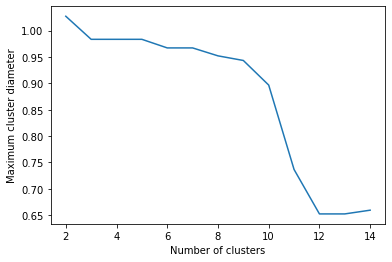

In [23]:
evaluate_agglomerative_clusters(HR_data_cosine, metric='cosine', linkage='average', nclusts=(2,14))    

The break in this curve is at 10 clusters.   

> **Exercise 04-5:** Compute a 10 cluster agglomerative model using average linkage, cosine for the distance metric, and display the frequency table of cluster assignment by `left`. 

In [24]:
nr.seed(8899)
HR_data_cosine['cluster_assignments'] = AgglomerativeClustering(n_clusters=10, linkage='average', affinity='cosine').fit_predict(HR_data_cosine)
HR_data_cosine.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)

cluster_assignments  left
0                    -1.0     549
                      1.0     204
1                    -1.0      15
2                    -1.0     539
3                    -1.0     509
4                    -1.0    9147
                      1.0    2858
5                    -1.0      13
6                     1.0     215
7                    -1.0     655
                      1.0     203
8                     1.0      91
9                    -1.0       1
dtype: int64

> Examine the frequency table and answer the following questions:   
> 1. Are any of the records of the employees who left in clusters separated from records of clusters of employees who have not left? Make sure you account for the encoding of the `left` column.       
> 2. Does the relationships in these clusters lead you to think that this model is over-fit with the clusters fragmented and why?  
> **End of exercise.**

Both Cluster 8 and Cluster 6 contain only records of employees that have left.

This model defintley seems like it is overfit. A majority of the records of employees that left are clusttered together with employees that stayed. In addition, it looks like cluster 4 holds a vast majority of the total data for some reason.

## Spectral Clustering   

Spectral clustering is a graph-based clustering algorithm. In summary, the algorithm uses the following steps:  

1. Create an undirected graph of the data samples. This graph can be fully connected or use only nearest-neighbors. The edge weights are the similarity between the samples. An association matrix is created from this graph.  
2. The graph Laplacian matrix is computed. 
2. An eigen-decomposition of the graph Laplacian is performed. The k eigenvectors corresponding to the smallest nonzero eigenvalues define the **spectrum** of the graph.   
3. A clustering algorithm is applied to the eigenvectors. Typically, a k-means algorithm is used.  

> **Exercise 04-6:** You will now apply the [sklearn.cluster.SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) function to compute a spectral clustering model.  
> 1. Start with the original data encoding (not the cosine similarity encoding) and make sure there is no cluster assignment column.   
> 2. Fit a model using `[sklearn.cluster.SpectralClustering` with the following arguments; `assign_labels='discretize'`, `n_clusters=8`, `affinity='nearest_neighbors'`, `n_neighbors=50`, and `random_state=0`, using the `fit_predict` method.  
> 3. Compute and print the frequency table of the cluster assignments.      
> **Note on algorithm:** In this case the spectral clustering algorithm is using nearest neighbor affinity, rather than a fully connected graph. This choice has several consequences. First, the affinity matrix is sparse, making the calculation of the eigenvectors considerably faster, although it may take some time to execute this code as it is. Second, the `SpectralClustering` function will raise a warning that the embedding is an approximation, since the graph is not fully connected.  

In [32]:
nr.seed(7788)

if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
    
model_spectral = SpectralClustering(n_clusters=8, assign_labels='discretize', affinity='nearest_neighbors', n_neighbors=50, random_state=0)

HR_data['cluster_assignments'] = model_spectral.fit_predict(HR_data)

HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)



cluster_assignments  left
0                    1       1030
1                    0       3670
2                    0       2517
3                    0        609
                     1          1
4                    1       1404
5                    1       1136
6                    0       1619
7                    0       3013
dtype: int64

> Answer the following questions.   
> - Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> - Given the above, does this model appear to identify some structure in the data which might provide insight into employees leaving the company?    

> To further evaluate this model, create and execute the code in the cell below to display the pair-wise scatter plot matrix and examine the results. You will likely see warnings about zero variance variables, which is expected when clusters contain only 1 or a few elements of a class.     

Yes, all but one employee who left are found in clusters that contain only other employees that left.

Yes, this clustering method appears to have identified some structure in the data for identifying why some emplyees choose to leave.

/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


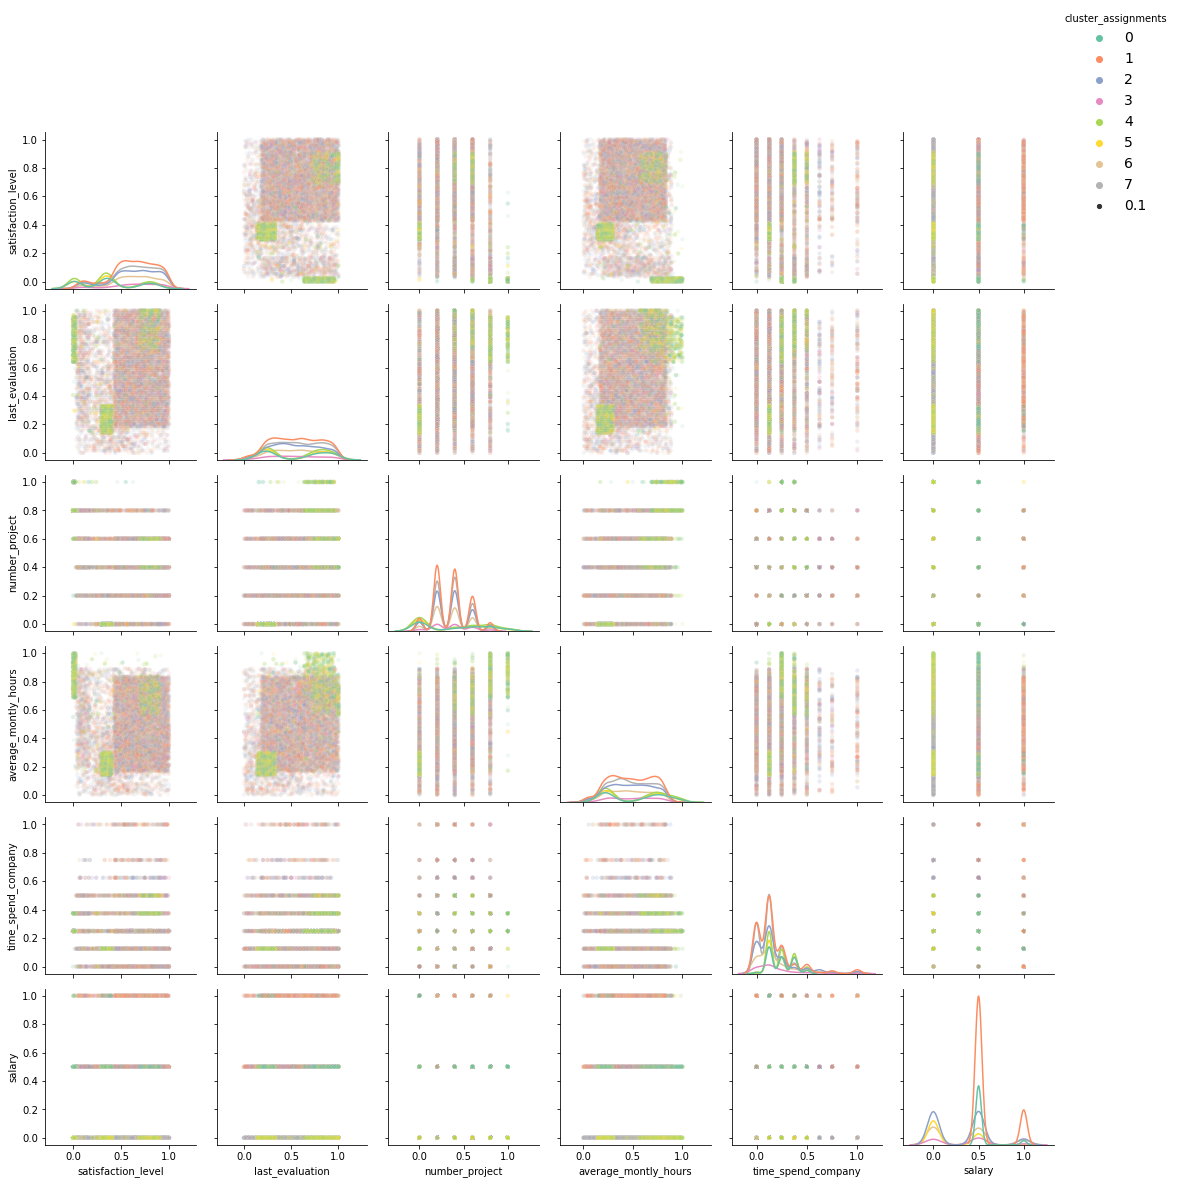

In [33]:
plot_cluster_assignments(HR_data)


> Examine this plot displaying 8 clusters. Are the clusters containing the employees leaving displayed in the plots in tight (small) clusters?     

> Next, create and execute code in the cell below to display violin plots to further explore the relationships in the clusters. Do this for satisfaction level, number of projects, and average monthly hours by cluster assignment.  

I really only see a tight clustering for cluster 4 which contains a majority of the records where employees left.

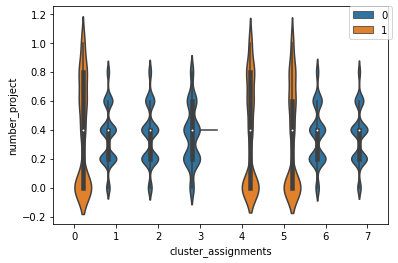

In [34]:
plot_clusters_by_factor(HR_data)    
plot_clusters_by_factor(HR_data, factor='number_project')  
plot_clusters_by_factor(HR_data, factor='average_montly_hours') 


> These results look similar to the those from the 8 cluster k-means algorithm. However, in detail there are some differences representing the different algorithms used. Some points to notice here include:   
> - Is there evidence that employees with low satisfaction are likely to leave the company? 
> - Is there evidence that employees with high and low numbers of projects and average monthly hours worked are likely to leave the company?       
> **End of exercise.**

This spectral cluster really emphasizes that employees with low satisfaction levels are likely to leave. Even more than the previous clusterings.

Similar to satisfaction level, employees with a low number of projects seem more likely to leave.

Employees with average monthly hours that are in the extreme ends of the spectrum (very low or very high) seem to be likely to leave.

## Density Clustering with OPTICS

The OPTICS algorithm is an example of a density clustering algorithm. The algorithm constructs a graph of the data samples. Samples in the dense core of the clusters are connected by undirected edges. Samples on the periphery of the clusters are corrected by directed edges. Samples too far from any cluster are unconnected to any cluster. Unlike the other models you have worked with in this assignment, OPTICS does not require the specification of the number of clusters.   

> **Exercise 04-7:** You will now apply the OPTICS algorithm to the HR data set.      
> 1. Start with the original data encoding (not the cosine similarity encoding) and make sure there is no cluster assignment column.   
> 2. Fit a model using [sklearn.cluster.OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) with the following arguments; `p=2`, `min_samples=250`. Use the `fit` method, not fit_predict. Make sure you name your model object `optics_model`. We will use the cluster model object a bit later.    
> 3. Extract the cluster labels from the model object, which are the `.labels_` attribute of the object. 
> 4. Compute and print the frequency table of the cluster assignments.      
> **Note:** Executing this code may take some time. 

In [35]:
nr.seed(4512)

if 'cluster_assignments' in HR_data.columns: HR_data.drop(columns='cluster_assignments', inplace=True)
    
optics_model = OPTICS(p=2, min_samples=250)
optics_model.fit(HR_data)

HR_data['cluster_assignments'] = optics_model.labels_

HR_data.loc[:,['cluster_assignments','left']].value_counts().sort_index(axis=0, level=0)


cluster_assignments  left
-1                   0        302
                     1       1050
 0                   1        303
 1                   1        592
 2                   1        348
 3                   1        362
 4                   1        396
 5                   1        265
 6                   1        255
 7                   0       6683
 8                   0       2517
 9                   0       1412
 10                  0        514
dtype: int64

> Answer the following questions.   
> - Notice the cluster with label `-1`. These are samples that are too far from any cluster code to be assigned a label. How do you think these unassigned cases affect the interpretation of the model?  
> - Are the majority of the records of employees who left the company in clusters without employees who did not leave the company?   
> - Given the above, does this model appear to identify some structure in the data which might provide insight into employees leaving the company?    

> To further evaluate this model, execute the code in the cell below and examine the resulting pair-wise scatter plot matrix. You will likely see warnings about zero variance variables, which is expected when clusters contain only 1 or a few elements of a class.     

It looks like almost a third of the total samples of employees who left are unassigned to a cluster. This seems a bit alarming to me from a useability standpoint.

Every sample that included an employee that left, and was able to be assigned to a cluster, resides only in clusters made up of other employees that left. 

Yes, this clustering method appears to have identified some structure in the data for identifying why some emplyees choose to leave, however I would place less weight on the results of this model, compared with other models, because of the large number of samples it was unable to classify. 


/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/pbooth/opt/an

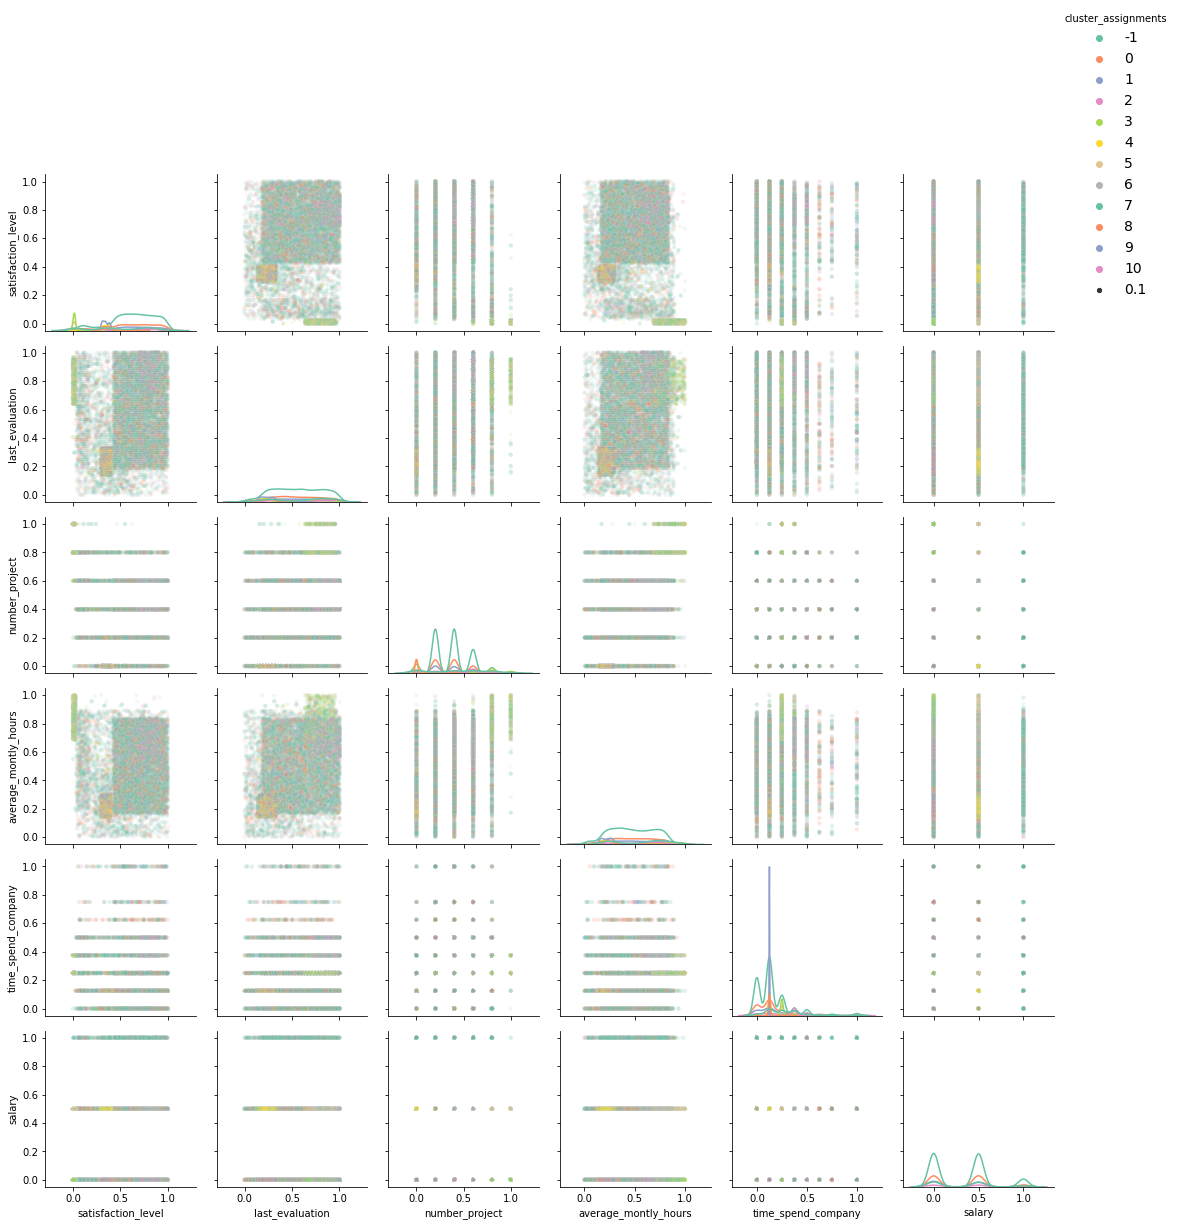

In [36]:
HR_temp = HR_data[HR_data.cluster_assignments > -1]
plot_cluster_assignments(HR_temp)

> Compared to the other cluster models you have tried, you can see that the clusters look rather diffuse and poorly formed. What does this suggest about the clusters labels, keeping the unassigned cases in mind?      

> To further evaluate this model, execute the code in the cell below and examine the resulting pair-wise scatter plot matrix.    

It suggests a lot of overlap between the clusters of employees who left and ones who stayed. 

This actually makes me think that this model didn't really identify a particularly useful structure to the data for identifying if an employee was likely to leave. The frequency table tells a different story than the pairwise scatter-plot matrix.

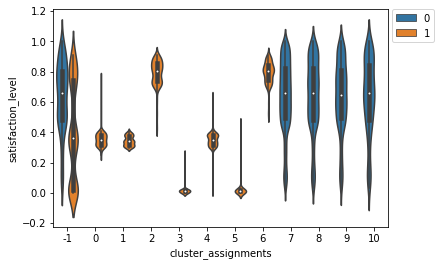

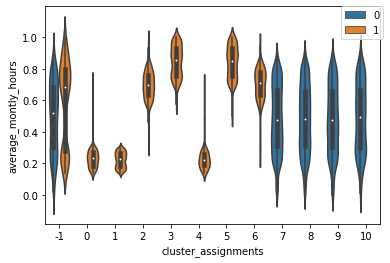

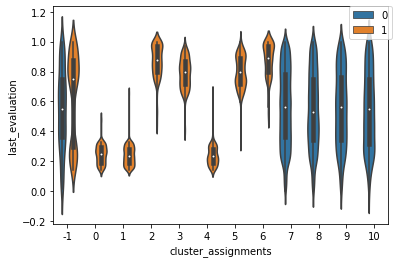

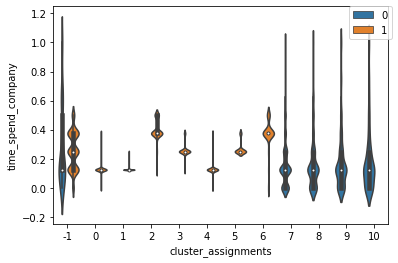

In [37]:
plot_clusters_by_factor(HR_data)    
plot_clusters_by_factor(HR_data, factor='number_project') #, type='box')  
plot_clusters_by_factor(HR_data, factor='average_montly_hours')   
plot_clusters_by_factor(HR_data, factor='last_evaluation')   
plot_clusters_by_factor(HR_data, factor='time_spend_company')  

> These results show considerable overlap in these variables for the cases of employees leaving and not. Is this result consistent with the foregoing observations with this model.             
> **End of exercise.**

In [ ]:
Yes, these results are consistent.

Finally, let's examine the reachability of the data samples for this density clustering model. The code in the cell below does the following:  
1. Extracts the ordered reachability and labels from the model object.    
2. Remove the cases where the sample is not a member of any cluster. 
3. Plot the reachability, using cluster label as the hue argument. 

/Users/pbooth/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


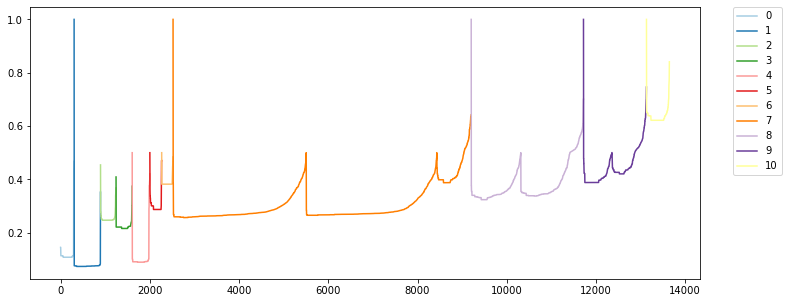

In [38]:
## Extract the ordered reachability and cluster labels
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]

## Remove the cases where the sample is not in a cluster
reachability = reachability[labels > -1]
labels = labels[labels > -1]

## Plot the graph
plt.figure(figsize=(12,5))
sns.lineplot(range(reachability[1:].shape[0]), reachability[1:], hue=labels[1:], legend="full", palette="Paired")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

What conclusions can we make from this graph? An important observation is that there is a wide range of reachability values for all the clusters. Further, the reachability of some clusters is much higher than for others. From these observations we can draw at least a few conclusions:   
1. The clusters have different densities of samples. This is expected and desirable given the complexity of the data.  
2. Most of these clusters must have some chain effect. This is evidenced by the fact that the range of reachability values varies greatly within most of the clusters. In simple terms, most of the clusters are not compact or well formed.  

#### Copyright 2018, 2019, 2020, 2021, Stephen F Elston. All rights reserved. 